# A Linear Regression model for predicting temperature

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd /content/drive/My\ Drive/GWU/Machine\ Learning/my_projects/weather

/content/drive/My Drive/GWU/Machine Learning/my_projects/weather


In [38]:
import warnings
warnings.filterwarnings('ignore')

## Preprocessing

### *Load data*

In [39]:
import pandas as pd
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the training data set
df_train = pd.read_csv('./weather_train.csv', header=0)
df_test = pd.read_csv('./weather_test.csv', header=0)

print(df_train.shape)
print(df_test.shape)

(77162, 12)
(19291, 11)


In [40]:
# Check the types of data per column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77162 entries, 0 to 77161
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            77162 non-null  object 
 1   Summary                   77162 non-null  object 
 2   Precip Type               76755 non-null  object 
 3   Temperature (C)           77162 non-null  float64
 4   Apparent Temperature (C)  77162 non-null  float64
 5   Humidity                  77162 non-null  float64
 6   Wind Speed (km/h)         77162 non-null  float64
 7   Wind Bearing (degrees)    77162 non-null  float64
 8   Visibility (km)           77162 non-null  float64
 9   Loud Cover                77162 non-null  float64
 10  Pressure (millibars)      77162 non-null  float64
 11  Daily Summary             77162 non-null  object 
dtypes: float64(8), object(4)
memory usage: 7.1+ MB


### *Understand the numerical data*

In [41]:
df_train.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,77162.000000,77162.000000,77162.000000,77162.000000,77162.000000,77162.000000,77162.0,77162.000000
mean,11.944444,10.870106,0.734721,10.816724,187.669397,10.358285,0.0,1002.918145
std,9.539367,10.681869,0.195367,6.926236,107.291719,4.188659,0.0,118.220269
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.750000,2.333333,0.600000,5.828200,117.000000,8.372000,0.0,1011.880000
50%,12.033333,12.033333,0.780000,9.949800,180.000000,10.046400,0.0,1016.430000
75%,18.822222,18.822222,0.890000,14.135800,290.000000,14.812000,0.0,1021.030000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


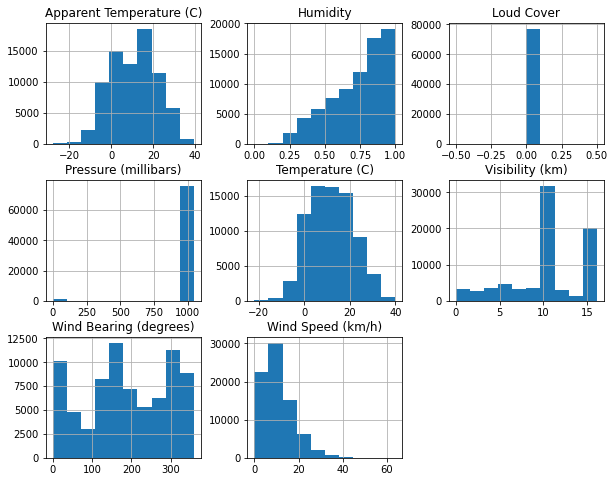

In [42]:
# print histograms to get a sense of the data and the distribution per feature
%matplotlib inline
import matplotlib.pyplot as plt
df_train.hist(figsize=(10,8))
plt.show()

### *Understand the categorical data*

In [43]:
# All values are zero
df_train['Loud Cover'].value_counts()

0.0    77162
Name: Loud Cover, dtype: int64

In [44]:
df_train['Precip Type'].value_counts()

rain    68233
snow     8522
Name: Precip Type, dtype: int64

In [45]:
#columns = ['Loud Cover','Apparent Temperature (C)']
columns = ['Loud Cover']
# Get rid of irrelevant
df_train = df_train.drop(columns, axis=1)
df_test = df_test.drop(columns, axis=1)

print(df_train.shape)
print(df_test.shape)

(77162, 11)
(19291, 10)


### *Convert datetime variables*

In [46]:
def datetime_transformer(df, datetime_vars):

    dict_ = {'year'   : lambda x : x.dt.year,
             'month'  : lambda x : x.dt.month,
             'day'    : lambda x : x.dt.day,
             'hour'   : lambda x : x.dt.hour}
             #'minute' : lambda x : x.dt.minute,
             #'second' : lambda x : x.dt.second}
    
    df_datetime = df.copy(deep=True)

    for var in datetime_vars:
        df_datetime[var] = pd.to_datetime(df_datetime[var],utc=True,errors='coerce')

        #create new columns and extract operator
        for datetime_type, datetime_type_operator in dict_.items():
            df_datetime['Date' + '_' + datetime_type] = datetime_type_operator(df_datetime[var])
            
    # Remove original column
    df_datetime = df_datetime.drop(columns=datetime_vars)
                
    return df_datetime

In [47]:
df_train = datetime_transformer(df_train, ['Formatted Date'])
df_test = datetime_transformer(df_test, ['Formatted Date'])
df_train.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Date_year,Date_month,Date_day,Date_hour
0,Overcast,rain,15.438889,15.438889,0.96,10.8675,0.0,5.1359,1014.97,Mostly cloudy throughout the day.,2010,9,17,23
1,Breezy and Partly Cloudy,rain,6.027778,1.133333,0.67,33.5041,302.0,11.3988,1010.07,Breezy until evening and foggy in the morning.,2013,3,22,15
2,Mostly Cloudy,rain,18.238889,18.238889,0.97,5.7316,262.0,14.6832,1010.24,Mostly cloudy throughout the day.,2016,6,12,7
3,Partly Cloudy,rain,10.227778,10.227778,0.66,3.2200,310.0,9.9820,1018.47,Partly cloudy starting in the morning continui...,2008,5,7,19
4,Mostly Cloudy,rain,7.950000,5.538889,0.76,14.0070,300.0,9.9820,1016.88,Mostly cloudy starting overnight.,2010,4,2,18


### *Correlations*


In [48]:
# Apparent temperature is highly correlated with temperature
corr_matrix = df_train.corr()
corr_matrix["Temperature (C)"].sort_values(ascending=False)

Temperature (C)             1.000000
Apparent Temperature (C)    0.992605
Visibility (km)             0.392092
Date_month                  0.151052
Date_hour                   0.096552
Wind Bearing (degrees)      0.027122
Date_year                   0.016596
Wind Speed (km/h)           0.008297
Date_day                   -0.002093
Pressure (millibars)       -0.005124
Humidity                   -0.633043
Name: Temperature (C), dtype: float64

In [49]:
# drop apparent temperature
columns = ['Apparent Temperature (C)']
df_train = df_train.drop(columns, axis=1)
df_test = df_test.drop(columns, axis=1)

print(df_train.shape)
print(df_test.shape)

(77162, 13)
(19291, 12)


## Prepare the data for Machine Learning Algorithms

### *Define the target*

In [50]:
target = 'Temperature (C)'

### *Divide train and validation datasets*

In [51]:
from sklearn.model_selection import train_test_split

# Divide: 80% as training set and 20% as validation
df_train, df_valid = train_test_split(df_train, 
                                      train_size=.8, 
                                      random_state=42)

# Reset the index in training and validation sets
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(61729, 13)
(15433, 13)
(19291, 12)


### *Handle identifiers*

In case the data has identifiers, we need to drop them because they do not have any predictive power.

In [52]:
# define function
def id_checker(df):
    df_id = df[[var for var in df.columns 
                if df[var].nunique(dropna=True) == df[var].notnull().sum()]] 
    
    if df_id.shape[1]==0:
      return "The data has no identifiers."
    else:     
      return df_id

# Call fuction 
id_checker(df_train)

'The data has no identifiers.'

### *Missing data*

In [53]:
def nan_checker(df):
    # Get the variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False)
    
    return df_nan

In [54]:
# Combine train, validation and test sets
df = pd.concat([df_train, df_valid, df_test], sort=False)

# Call nan_checker on df
df_nan = nan_checker(df)

# Print df_nan
df_nan.reset_index(drop=True)

,var,proportion,dtype
0,Temperature (C),0.200004,float64
1,Precip Type,0.005360,object


In [55]:
import numpy as np

#Remove missing values from training set 
df_train = df_train.dropna(subset=np.intersect1d(df_nan['var'],df_train.columns), inplace=False)

#Remove missing values from validation set 
df_valid = df_valid.dropna(subset=np.intersect1d(df_nan['var'],df_valid.columns), inplace=False)

#Remove missing values from test set 
df_test = df_test.dropna(subset=np.intersect1d(df_nan['var'],df_test.columns), inplace=False)


print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(61400, 13)
(15355, 13)
(19181, 12)


### *One-hot encoding of categorical data*

In [56]:
def cat_var_checker(df):
    # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)]
                           for var in df.columns if df[var].dtype == 'object'],
                          columns=['var', 'nunique'])
    
    # Sort df_cat in accending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False)
    
    return df_cat

In [57]:
# Combine train, validation and test sets
df = pd.concat([df_train, df_valid, df_test], sort=False)

# Call cat_var_checker on df
df_cat = cat_var_checker(df)

# Print the dataframe
df_cat.reset_index(drop=True)

,var,nunique
0,Daily Summary,214
1,Summary,27
2,Precip Type,2


In [58]:
# Drop categorical feature with many values
df = df.drop(columns=['Daily Summary'])

In [59]:
# Encode the categorical features
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']),[target]))

# Print the first rows
df.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Date_year,Date_month,Date_day,Date_hour,Precip Type_rain,Precip Type_snow,Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,Summary_Breezy and Overcast,Summary_Breezy and Partly Cloudy,Summary_Clear,Summary_Dangerously Windy and Partly Cloudy,Summary_Drizzle,Summary_Dry,Summary_Dry and Mostly Cloudy,Summary_Dry and Partly Cloudy,Summary_Foggy,Summary_Humid and Mostly Cloudy,Summary_Humid and Overcast,Summary_Humid and Partly Cloudy,Summary_Light Rain,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy
0,12.044444,0.74,9.3058,201.0,15.8263,1013.79,2015,5,1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,12.950000,0.85,26.2108,302.0,14.9569,1005.99,2014,5,11,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,37.650000,0.20,12.7834,286.0,10.3523,1012.35,2012,8,6,12,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5.488889,0.94,3.2200,230.0,2.4955,1015.10,2015,1,19,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7.755556,0.89,9.3058,312.0,9.7083,1005.52,2014,10,23,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [60]:
# Separate the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separate the validation data
df_valid = df.iloc[df_train.shape[0]:
                   df_train.shape[0] + df_valid.shape[0],:].copy(deep=True)

# Separate the testing data
df_test = df.iloc[df_train.shape[0] + df_valid.shape[0]:,:].copy(deep=True)

# Print the dimension of the training and testing data
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(61400, 39)
(15355, 39)
(19181, 39)


### *Standardize numerical data*

In [61]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

df_ss_train = pd.DataFrame(ss.fit_transform(df_train), columns=df_train.columns)
df_ss_valid = pd.DataFrame(ss.transform(df_valid), columns=df_valid.columns)
df_ss_test = pd.DataFrame(ss.transform(df_test), columns=df_test.columns)

### *Feature matrix and vector matrix*

In [62]:
# Get the feature matrix
X_train = df_ss_train[np.setdiff1d(df_ss_train.columns, [target])]
X_valid = df_ss_valid[np.setdiff1d(df_ss_valid.columns, [target])]
X_test = df_ss_test[np.setdiff1d(df_ss_test.columns, [target])]

# Get the target vector
y_train = df_ss_train[target]
y_valid = df_ss_valid[target]

## Linear Regression: the simplest model

In [63]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

# Train the linear regression model on the training data using X_train and y_train
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
from sklearn.metrics import mean_squared_error

# Get the prediction on the training data using lr
y_train_pred = lr.predict(X_train)

# Get the MSE
lin_mse = mean_squared_error(y_train, y_train_pred)
lin_rmse = np.sqrt(lin_mse) 
#print(lin_mse)
print(lin_rmse)

0.6108636924688448


 **The model might be overfitting the training data. 
Let's see if we can do better. The model needs regularization to avoid overfitting. We will compare L1, L2 and Elastic Net regularizarion. Also, we will use Grid Search to fine tune the hyperparameters.** 

## Linear Regression: Hperparameter tuning and model selection

### *Dictionary of models*

In [65]:
# Dictionary of models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

models = {'lr': LinearRegression(),
          'lasso': Lasso(random_state=42),
          'ridge': Ridge(random_state=42),
          'en': ElasticNet(random_state=42)}

### *Dictionary of the pipelines*

In [66]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

### *Predifined cross-validator*



In [67]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = pd.concat([X_train, X_valid], ignore_index=True, sort=False)

# Combine the target vector in the training and validation data
y_train_valid = pd.concat([y_train, y_valid], ignore_index=True, sort=False)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

### *Grid search*

In [68]:
param_grids = {}

# Linear regression
# Not essential to tune this since LR is based on a close formed of the Normal Equation
param_grids['lr'] = [{}]

# Lasso
alpha_grids = [10 ** i for i in range(-4, 5)]
param_grids['lasso'] = [{'model__alpha': alpha_grids}]

# Ridge
alpha_grids = [10 ** i for i in range(-4, 5)]
param_grids['ridge'] = [{'model__alpha': alpha_grids}]

# Elastic net
alpha_grids = [10 ** i for i in range(-4, 5)]
l1_ratio_grids = [0.1 * i for i in range(11)]
param_grids['en'] = [{'model__alpha': alpha_grids,
                      'model__l1_ratio': l1_ratio_grids}]

In [69]:
# Create the directory to store results of Grid Search
import os

# Make directory
directory = os.path.dirname('./cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

### *Hyperparameter tuning*

Fine-tune the hyperparameters of Lasso, Ridge and ElasticNet (using sklearn GridSearchCV).

In [70]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='neg_mean_squared_error',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='./cv_results/GridSearchCV/' + acronym + '.csv', index=False)

### *Model selection*

In [71]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
df_scores = pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])
df_scores

,best_score,best_param,best_estimator
0,-3.733050e-01,"{'model__alpha': 0.01, 'model__l1_ratio': 0.0}","(ElasticNet(alpha=0.01, copy_X=True, fit_inter..."
1,-3.733112e-01,{'model__alpha': 100},"(Ridge(alpha=100, copy_X=True, fit_intercept=T..."
2,-3.733199e-01,{'model__alpha': 0.0001},"(Lasso(alpha=0.0001, copy_X=True, fit_intercep..."
3,-6.095502e+18,{},"(LinearRegression(copy_X=True, fit_intercept=T..."


**All models with regularization perform better than simple regression model without regularization. Also, it seems that Elastic Net has the smallest negative mean squared error.**